# DNBLab Jupyter Notebook Tutorial

## SRU - Schnittstellenabfrage, Datenauslieferung und Ergebnisanzeige

Dieses DNBLab-Tutorial beschreibt eine Beispielabfrage über die SRU-Schnittstelle mit Python. In der Jupyter Notebook Umgebung kann der dokumentierte Code direkt ausgeführt und angepasst werden. Das Tutorial umfasst die exemplarische Anfrage und Ausgabe der Daten in MARC21-xml zur weiteren Verarbeitung. 

Die Daten können über die SRU-Schnittstelle als XML-Antwort in folgenden Formaten ausgeliefert werden: 
* MARC21-xml http://www.loc.gov/standards/marcxml/schema/MARC21slim.xsd
* DNB Casual (oai_dc)	http://www.openarchives.org/OAI/2.0/oai_dc.xsd
* RDF (RDFxml) http://www.w3.org/2000/07/rdf.xsd

## Einrichten der Arbeitsumgebung <a class="anchor" id="Teil1"></a>

Um die Arbeitsumgebung für die folgenden Schritte passend einzurichten, sollten zunächst die benötigten Python-Bibliotheken importiert werden. Für Anfragen über die SRU-Schnittstelle wird Requests https://docs.python-requests.org/en/latest/ und zur Verarbeitung der XML-Daten etree https://docs.python.org/3/library/xml.etree.elementtree.html verwendet. Mit Pandas https://pandas.pydata.org/ können Elemente aus dem MARC21-Format ausgelesen werden.

In [17]:
import requests
from bs4 import BeautifulSoup as soup
import unicodedata
from lxml import etree
import pandas as pd
import warnings
import matplotlib.pyplot as plt

## SRU-Abfrage mit Ausgabe in MARC21-xml<a class="anchor" id="Teil2"></a>

Die Funktion dnb_sru nimmt den Paramter "query" der SRU-Abfrage entgegen und liefert alle Ergebnisse als eine Liste von Records aus. Bei mehr als 100 Records werden weitere Datensätze mit "&startRecord=101" abgerufen (mögliche Werte 1 bis 99.000). Weitere Informationen und Funktionen der SRU- Schnittstelle werden unter https://www.dnb.de/sru beschrieben.

In [35]:
def dnb_sru(query):
    base_url = "https://services.dnb.de/sru/dnb"
    params = {
        'recordSchema': 'MARC21-xml',
        'operation': 'searchRetrieve',
        'version': '1.1',
        'maximumRecords': '100',
        'query': query
    }
    r = requests.get(base_url, params=params)
    xml = soup(r.content, 'xml')
    records = xml.find_all('record', {'type': 'Bibliographic'})
    
    # URL der SRU-Abfrage ausgeben
    print("SRU Query URL:", r.url)
    
    if len(records) < 100:
        return records
    else:
        num_results = 100
        i = 101
        while num_results == 100:
            params.update({'startRecord': i})
            r = requests.get(base_url, params=params)
            xml = soup(r.content, 'xml')
            new_records = xml.find_all('record', {'type': 'Bibliographic'})
            records += new_records
            i += 100
            num_results = len(new_records)
        
        return records


## Durchsuchen eines MARC-Feldes<a class="anchor" id="Teil3"></a>

Die Funktion parse_records nimmt als Parameter jeweils ein Record entgegen und sucht über xpath die gewünschte Informationen heraus und liefert diese als Dictionary zurück. Die Schlüssel-Werte-Paare können beliebig agepasst und erweitert werden. In diesem Fall werden Elemente für IDN und Titel geliefert.

Für unsere Analyse extrahieren wir die Felder IDN, Titel, Autor, Erscheinungsjahr und GND-ID.

Die GND-ID wird benötigt, Autoren*innen auch unter anderen Namen finden zu können. Zur Suche der GND-ID können wir den GND Explorer unter https://explore.gnd.network/ verwenden. 

In [19]:
from lxml import etree
import unicodedata

def parse_record(record):
    ns = {"marc": "http://www.loc.gov/MARC21/slim"}
    xml = etree.fromstring(unicodedata.normalize("NFC", str(record)))
    
    # idn
    idn = xml.xpath("marc:controlfield[@tag = '001']", namespaces=ns)
    try:
        idn = idn[0].text
    except:
        idn = 'fail'
    
    # titel
    titel = xml.xpath("marc:datafield[@tag = '245']/marc:subfield[@code = 'a']", namespaces=ns)
    try:
        titel = titel[0].text
    except:
        titel = "unknown"
    
    # autor
    autor = xml.xpath("marc:datafield[@tag = '100']/marc:subfield[@code = 'a']", namespaces=ns)
    try:
        autor = autor[0].text
    except:
        autor = "unknown"
        
    # erscheinungsjahr
    erscheinungsjahr = xml.xpath("marc:datafield[@tag = '264']/marc:subfield[@code = 'c']", namespaces=ns)
    if not erscheinungsjahr:
        erscheinungsjahr = xml.xpath("marc:datafield[@tag = '260']/marc:subfield[@code = 'c']", namespaces=ns)
    try:
        erscheinungsjahr = erscheinungsjahr[0].text
    except:
        erscheinungsjahr = "unknown"
        
    # GND-ID
    gnd_id = xml.xpath("marc:datafield[@tag = '035']/marc:subfield[@code = 'a']", namespaces=ns)
    if not gnd_id:
        gnd_id = xml.xpath("marc:datafield[@tag = '024']/marc:subfield[@code = 'a']", namespaces=ns)
    try:
        gnd_id = gnd_id[0].text
    except:
        gnd_id = "unknown"
        
    meta_dict = {
        "idn": idn,
        "titel": titel,
        "autor": autor,
        "erscheinungsjahr": erscheinungsjahr,
        "gnd_id": gnd_id
    }
    
    return meta_dict


Über die verschiedenen Indices https://services.dnb.de/sru/dnb?operation=explain&version=1.1 kann die SRU-Abfrage mittels CQL gezielt z.B. über das Titelstichwort "Klimawandel" in Kombination mit dem Standort "online frei verfügbar" eingeschränkt werden. Auf diese Art kann durch Anpassen des Codes nach verschiedenen Begriffen in beliebigen MARC-Feldern gesucht werden. 

In [37]:
records = dnb_sru('creator="Tieck, Ludwig"')
print(len(records), 'Ergebnisse')

SRU Query URL: https://services.dnb.de/sru/dnb?recordSchema=MARC21-xml&operation=searchRetrieve&version=1.1&maximumRecords=100&query=creator%3D%22Tieck%2C+Ludwig%22
823 Ergebnisse


In [36]:
records = dnb_sru('creator="Bernhardi, Sophie"')
print(len(records), 'Ergebnisse')

SRU Query URL: https://services.dnb.de/sru/dnb?recordSchema=MARC21-xml&operation=searchRetrieve&version=1.1&maximumRecords=100&query=creator%3D%22Tieck%2C+Ludwig%22
823 Ergebnisse


## Aufgabe 1

Kombinieren Sie die beiden Suchanfragen so, dass gleichzeitig nach Sophie Bernhardi und Ludwig Tieck gesucht wird.

In [22]:
# Hier die Lösung eintragen

<details>
   <summary><strong>Lösung (hier klicken)</strong></summary>
   <p>records = dnb_sru('creator="Tieck, Ludwig" or creator="Bernhardi, Sophie"')</p>
<p>print(len(records), 'Ergebnisse')</p>
</details>



In [23]:
records = dnb_sru('creator="Tieck, Ludwig" or creator="Bernhardi, Sophie"')

print(len(records), 'Ergebnisse')

852 Ergebnisse


## Beispielanzeige zur weiteren Bearbeitung <a class="anchor" id="Teil4"></a>

Mit der "Python Data Analysis Library" Pandas für Python werden die Ergebnisse (Dictionary-Elemente) als Dataframe ausgegeben. Die ersten 5 und letzten 5 Zeilen des Dataframes können mit dem Befehl "df = pd.DataFrame() angezeigt werden. 

In [24]:
output = [parse_record(record) for record in records]
df = pd.DataFrame(output)
df

,idn,titel,autor,erscheinungsjahr,gnd_id
0,1345989512,Abendgespräche,"Ludwig Tieck, Ludwig",2024,(DE-599)DNB1345989512
1,1343337054,Den blonde Eckbert och andra berättelser,"Tieck, Ludwig.",2024,(DE-599)DNB1343337054
2,1331954304,Denkwürdige Geschichtschronik der Schildbürger,"Tieck, Ludwig",2024,(DE-599)DNB1331954304
3,1316431975,Der blonde Eckbert,"Tieck, Ludwig",2024,(DE-599)DNB1316431975
4,134170534X,Der blonde Eckbert,"Tieck, Ludwig",2024,(DE-599)DNB134170534X
...,...,...,...,...,...
847,458342793,Werke,"Tieck, Ludwig",unknown,(DE-599)DNB458342793
848,997581743,Werke,"Tieck, Ludwig",unknown,(DE-599)DNB997581743
849,550418636,Werke in vier Bänden,"Tieck, Ludwig",unknown,(DE-599)DNB550418636
850,550508554,Werke in vier Bänden,"Tieck, Ludwig",unknown,(DE-599)DNB550508554


Mit der folgenden Funktion df.to_csv() werden die Ergebnisse als SRU_Titel.csv in dem Navigationsverzeichnis abgelegt und können dort heruntergeladen werden. 

In [25]:
df.to_csv("SRU_Tieck.csv", index=False)

## Titelanalyse 

Anschließend soll analysiert werden, wie viele Titel von Tieck, Ludwig und Bernhardi, Sophie, geschrieben wurden. Eine gute Möglichkeit, um sich Programmierunterstützung zu holen, ist die Nutzung von KI-basierten Chattools. Dabei kommt es auf die richtige Prompterstellung an. 

## Aufgabe 2

Erstellen Sie einen Beispielprompt, der basierend auf unserer Ausgabe ein Kreis- und Balkendiagramm erstellt. 

<details>
   <summary><strong>Beispiellösung (hier klicken)</strong></summary>
   <p>Ich habe ein Jupyter Notebook basierend auf Python. Ich möchte meinen bereits erstellten Pandas DataFrame auswerten lassen. Dabei soll analysiert werden, wie viele Werke je Autor erschienen sind. Die Spalte im DataFrame heißt "autor". Bitte erkläre mir entsprechende Codeteile. Das Ergebnis soll als Balken- und Kreisdiagramm herausgegeben werden.</p>
</details>

In [ ]:
# Platz für Ihren Code

Beispielergebnis: 

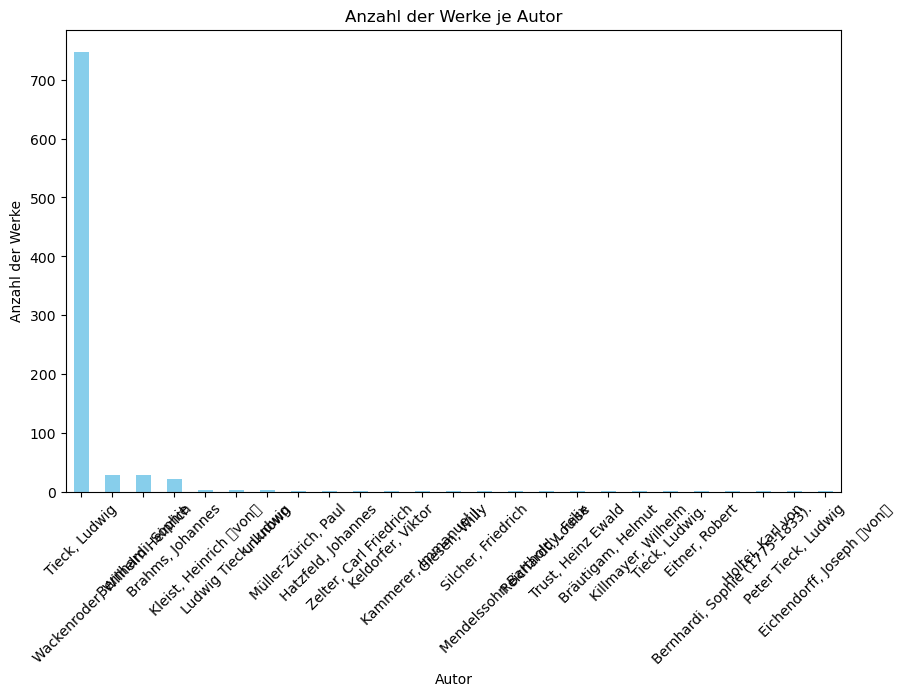

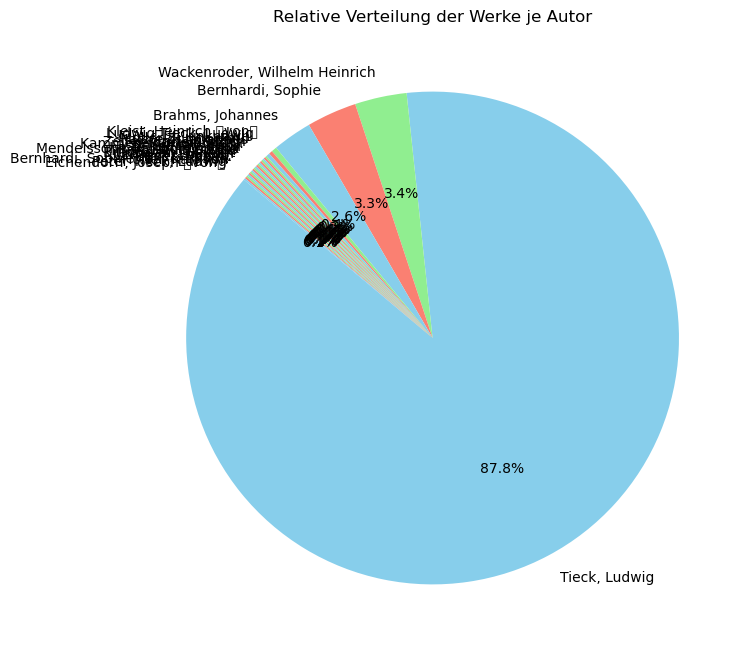

In [26]:
# Anzahl der Werke je Autor berechnen
works_per_author = df['autor'].value_counts()

# Warnungen unterdrücken
warnings.filterwarnings("ignore", category=UserWarning, module="IPython.core.pylabtools")

# Balkendiagramm
plt.figure(figsize=(10, 6))
works_per_author.plot(kind='bar', color='skyblue')
plt.title('Anzahl der Werke je Autor')
plt.xlabel('Autor')
plt.ylabel('Anzahl der Werke')
plt.xticks(rotation=45)
plt.show()

# Kreisdiagramm
plt.figure(figsize=(8, 8))
works_per_author.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon'])
plt.title('Relative Verteilung der Werke je Autor')
plt.ylabel('')  # Entfernt die Standard-Beschriftung
plt.show()


**Feintuning!**

Die Diagramme lassen sich weiterhin verbessern. Beispielsweise können  die TOP 5 Autor*innen ausgegeben werden lassen, um die Lesbarkeit deutlich zu verbessern.

C:\Users\fuchsf\AppData\Local\Temp\ipykernel_9040\2769968823.py:19: UserWarning: Glyph 152 (\x98) missing from current font.
  plt.tight_layout()  # Optimiert das Layout für bessere Lesbarkeit
C:\Users\fuchsf\AppData\Local\Temp\ipykernel_9040\2769968823.py:19: UserWarning: Glyph 156 (\x9c) missing from current font.
  plt.tight_layout()  # Optimiert das Layout für bessere Lesbarkeit


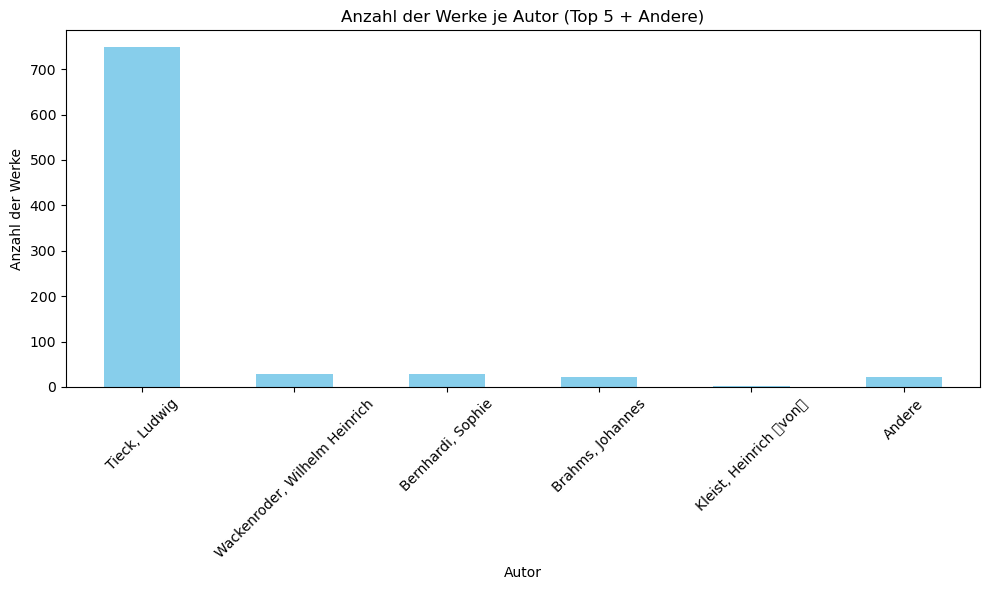

C:\Users\fuchsf\AppData\Local\Temp\ipykernel_9040\2769968823.py:38: UserWarning: Glyph 152 (\x98) missing from current font.
  plt.tight_layout()
C:\Users\fuchsf\AppData\Local\Temp\ipykernel_9040\2769968823.py:38: UserWarning: Glyph 156 (\x9c) missing from current font.
  plt.tight_layout()


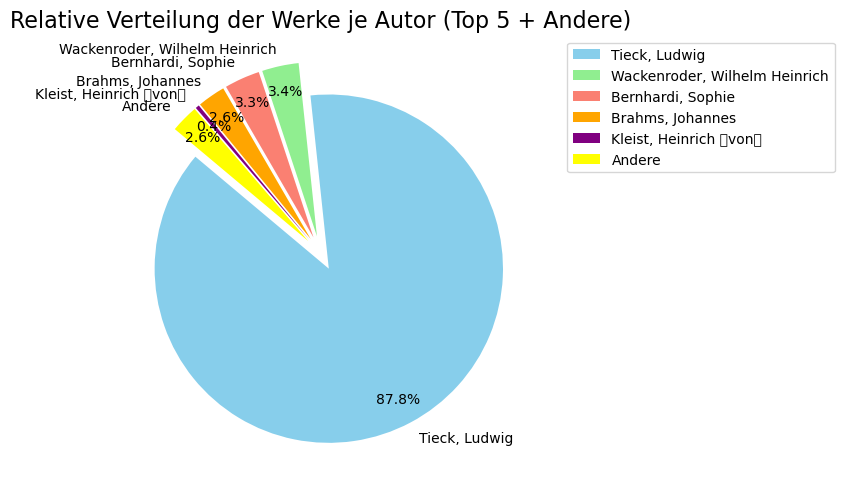

In [27]:
# Beispielwerte: Top 5 und Rest als "Andere" zusammenfassen
works_per_author = df['autor'].value_counts()
top_authors = works_per_author.nlargest(5)
top_authors['Andere'] = works_per_author.iloc[5:].sum()


warnings.filterwarnings("ignore", category=UserWarning, module="IPython.core.pylabtools")

# UserWarning für fehlende Glyphen unterdrücken
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Balkendiagramm für Top 5 und "Andere"
plt.figure(figsize=(10, 6))
top_authors.plot(kind='bar', color='skyblue')
plt.title('Anzahl der Werke je Autor (Top 5 + Andere)')
plt.xlabel('Autor')
plt.ylabel('Anzahl der Werke')
plt.xticks(rotation=45)
plt.tight_layout()  # Optimiert das Layout für bessere Lesbarkeit
plt.show()

# Kreisdiagramm mit Legende und Explosions-Effekt
plt.figure(figsize=(8, 8))
top_authors.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=140,
    colors=['skyblue', 'lightgreen', 'salmon', 'orange', 'purple', 'yellow', 'red', 'blue', 'gray', 'pink', 'brown'],
    explode=[0.1] * len(top_authors),  # Explosions-Effekt für alle Segmente
    pctdistance=0.85  # Abstand der Prozentwerte vom Mittelpunkt
)

plt.title('Relative Verteilung der Werke je Autor (Top 5 + Andere)', fontsize=16)
plt.ylabel('')  # Entfernt die Y-Achsen-Beschriftung

# Legende außerhalb des Diagramms platzieren
plt.legend(top_authors.index, bbox_to_anchor=(1.05, 1), loc='best')
plt.tight_layout()
plt.show()


## Daten normieren 

Es kann vorkommen, dass einige Werke mehrmals vorkommen, etwa bei unterschiedlichen Auflagen. Die drop_duplicates-Funktion entfernt doppelte Einträge basierend auf eindeutigen Merkmalen wie Titel oder einer eindeutigen ID.

In [28]:
# Duplikate basierend auf 'titel' entfernen und nur das erste Vorkommen behalten
df_unique_titles = df.drop_duplicates(subset='titel')

# Aktualisierter DataFrame ohne Duplikate
df_unique_titles


,idn,titel,autor,erscheinungsjahr,gnd_id
0,1345989512,Abendgespräche,"Ludwig Tieck, Ludwig",2024,(DE-599)DNB1345989512
1,1343337054,Den blonde Eckbert och andra berättelser,"Tieck, Ludwig.",2024,(DE-599)DNB1343337054
2,1331954304,Denkwürdige Geschichtschronik der Schildbürger,"Tieck, Ludwig",2024,(DE-599)DNB1331954304
3,1316431975,Der blonde Eckbert,"Tieck, Ludwig",2024,(DE-599)DNB1316431975
5,1325913553,Der Runenberg,"Tieck, Ludwig",2024,(DE-599)DNB1325913553
...,...,...,...,...,...
831,560974914,Märchen und Geschichten,"Tieck, Ludwig",unknown,(DE-599)DNB560974914
835,458342904,Schriften,"Tieck, Ludwig",unknown,(DE-599)DNB458342904
837,560974922,Straußfedern,"Tieck, Ludwig",unknown,(DE-599)DNB560974922
843,560974884,Werke,"Tieck, Ludwig",unknown,(DE-599)DNB560974884


Aufgrund bibliothekarischer Regelwerke erscheinen die Jahreszahlen nicht immer gleich. Um die Daten besser verarbeiten zu können, werden die Werte der Spalte 'erscheinungsjahr' aufgelistet. Hier werden die Unterschiede in den Daten deutlich. Ziel ist es, diese Daten ebenfalls zu normieren und für eine Auswertung vorzubereiten. 

In [29]:
# Alle Werte aus der Spalte 'erscheinungsjahr' in eine Liste extrahieren
erscheinungsjahre = df['erscheinungsjahr'].tolist()

# Liste der Jahreszahlen anzeigen
erscheinungsjahre


['2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2024',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '[2023]',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '2023',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2022',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '[2021?]',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '2021',
 '202

Dafür entfernen wir Sonderzeichen und Buchstaben, die nichts mit den Jahreszahlen zu tun haben. 

In [30]:
# Funktion zur Bereinigung der Jahreszahlen direkt im DataFrame
def clean_year_column(df, column_name):
    # Extrahiere nur Ziffern und konvertiere zu Integer, falls möglich
    df[column_name] = df[column_name].astype(str).str.extract('(\d+)').astype(float).astype('Int64')
    return df

# Anwendung auf die 'erscheinungsjahr'-Spalte
df = clean_year_column(df, 'erscheinungsjahr')

# Ergebnis zurückgeben
df


,idn,titel,autor,erscheinungsjahr,gnd_id
0,1345989512,Abendgespräche,"Ludwig Tieck, Ludwig",2024,(DE-599)DNB1345989512
1,1343337054,Den blonde Eckbert och andra berättelser,"Tieck, Ludwig.",2024,(DE-599)DNB1343337054
2,1331954304,Denkwürdige Geschichtschronik der Schildbürger,"Tieck, Ludwig",2024,(DE-599)DNB1331954304
3,1316431975,Der blonde Eckbert,"Tieck, Ludwig",2024,(DE-599)DNB1316431975
4,134170534X,Der blonde Eckbert,"Tieck, Ludwig",2024,(DE-599)DNB134170534X
...,...,...,...,...,...
847,458342793,Werke,"Tieck, Ludwig",<NA>,(DE-599)DNB458342793
848,997581743,Werke,"Tieck, Ludwig",<NA>,(DE-599)DNB997581743
849,550418636,Werke in vier Bänden,"Tieck, Ludwig",<NA>,(DE-599)DNB550418636
850,550508554,Werke in vier Bänden,"Tieck, Ludwig",<NA>,(DE-599)DNB550508554


## Datenanalyse

Sind alle benötigten Daten normiert, wird mit der eigentlichen Analyse gestartet. Die Datenbereinigung ist aufgrund vieler Regelwerke und Erschließungsrichtlinien, die historisch gewachsen sind, notwendig. Sie ist oft sehr zeitaufwendig und stellt einen Großteil der eigentlichen Arbeit an den Daten dar. 

Da unsere Jahreszahlen nun bereinigt sind, sollen sie unterteilt in 50-Jahre Abschnitte in einem Balkendiagramm visualisiert werden. 

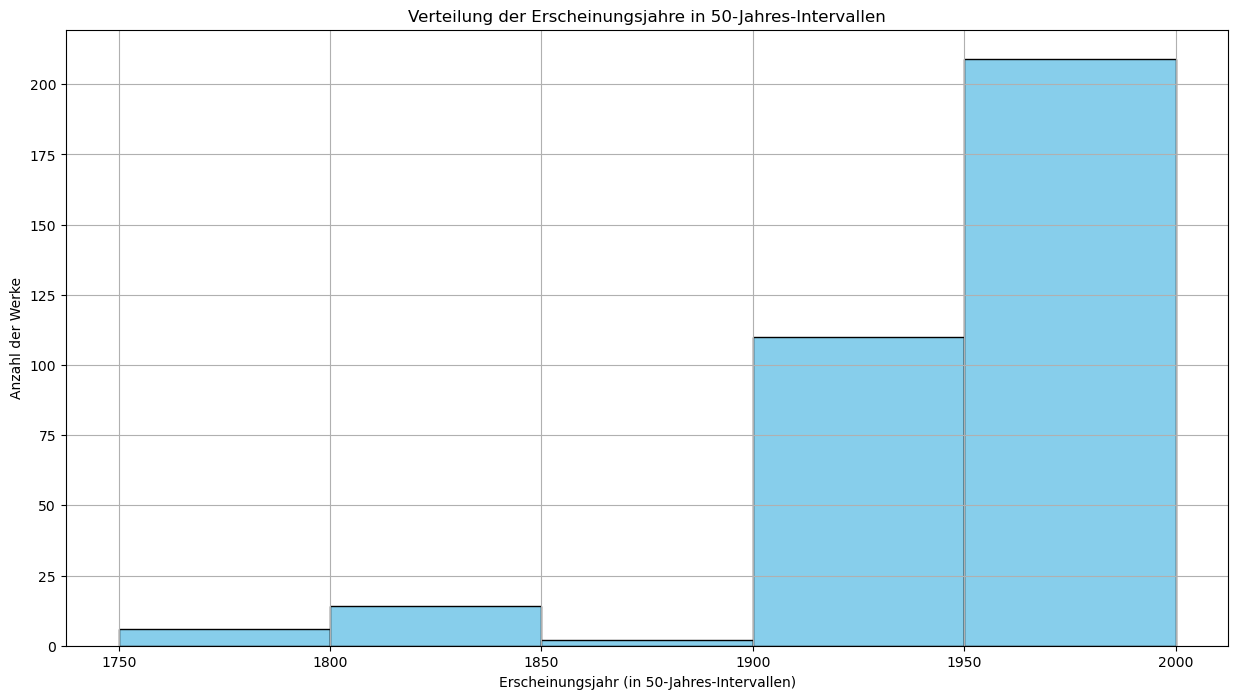

In [31]:
# Erscheinungsjahre aus der Spalte 'erscheinungsjahr' im DataFrame df extrahieren
years = df['erscheinungsjahr'].dropna().astype(int)  # Um sicherzustellen, dass es ganze Zahlen sind und keine NaN-Werte enthalten sind

# Histogramm erstellen
plt.figure(figsize=(15, 8))  # definiert die Größe des Diagramms
plt.hist(years, bins=range(1750, 2050, 50), color='skyblue', edgecolor='black')  # Bins auf 50er-Jahresintervalle setzen
plt.title('Verteilung der Erscheinungsjahre in 50-Jahres-Intervallen')
plt.xlabel('Erscheinungsjahr (in 50-Jahres-Intervallen)')
plt.ylabel('Anzahl der Werke')
plt.grid(True)
plt.show()
